In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
#create directories for testing training and validation

os.chdir('C:/users/ethan/data/Plant_Data')
if os.path.isdir('train/1/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(1,43):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 7)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 2)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')
                 

In [4]:
#stores all newly created folders in variables
train_path = 'C:/users/ethan/data/Plant_Data/train'
valid_path = 'C:/users/ethan/data/Plant_Data/valid'
test_path = 'C:/users/ethan/data/Plant_Data/test'

In [5]:
#setting up batches for all directories, processing them for mobile net, ensuring uniform size of images, and setting batch size
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=2, shuffle=False)


Found 430 images belonging to 10 classes.
Found 70 images belonging to 10 classes.
Found 20 images belonging to 10 classes.


In [6]:
assert train_batches.n == 430
assert valid_batches.n == 70
assert test_batches.n == 20
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

In [7]:
#import mobilenet
mobile = tf.keras.applications.mobilenet.MobileNet()

In [8]:
#displays all layers and parameter count for layers in nonmodified MobileNet
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [15]:
#gets rid of last 5 layers of MobileNet Model // test different amounts of layers later
#creates output layer
x = mobile.layers[-6].output
#passes x to the output layer, this is a functional model instead of sequential
#INFO:https://hanifi.medium.com/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e
output = Dense(units=10, activation='softmax')(x)

In [16]:
model = Model(inputs=mobile.input, outputs=output)

In [17]:
#makes all layers except for the last 24 untrainable, play with this number later
for layer in model.layers[:-24]:
    layer.trainable = False

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [19]:
#training model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# test number of epochs to find where diminishing returns are
#look into overfitting issue
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
43/43 - 16s - loss: 1.0276 - accuracy: 0.6465 - val_loss: 1.5768 - val_accuracy: 0.4571
Epoch 2/30
43/43 - 14s - loss: 0.1674 - accuracy: 0.9744 - val_loss: 0.8859 - val_accuracy: 0.6714
Epoch 3/30
43/43 - 14s - loss: 0.1039 - accuracy: 0.9860 - val_loss: 0.4521 - val_accuracy: 0.8143
Epoch 4/30
43/43 - 14s - loss: 0.0645 - accuracy: 0.9977 - val_loss: 0.2138 - val_accuracy: 0.9143
Epoch 5/30
43/43 - 14s - loss: 0.0412 - accuracy: 0.9977 - val_loss: 0.1660 - val_accuracy: 0.9571
Epoch 6/30
43/43 - 14s - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.1451 - val_accuracy: 0.9143
Epoch 7/30
43/43 - 14s - loss: 0.0295 - accuracy: 0.9977 - val_loss: 0.1936 - val_accuracy: 0.9429
Epoch 8/30
43/43 - 14s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.1219 - val_accuracy: 0.9429
Epoch 9/30
43/43 - 14s - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9429
Epoch 10/30
43/43 - 14s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.0994 - val_accuracy: 0.9714
Epoch 11/

In [21]:
test_labels = test_batches.classes

In [22]:
predictions = model.predict(x=test_batches, verbose=0)

In [23]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [24]:
test_batches.class_indices

{'1': 0,
 '10': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [28]:
cm_plot_labels = ['Cerris', 'Purpubascens', 'Hispanica', 'Kewensis', 'Ludoviciana', 'Mannifera', 'Rosacea', 'Turneri',
                  'Acutissima', 'Agrifolia', 'Arkansana']

In [30]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

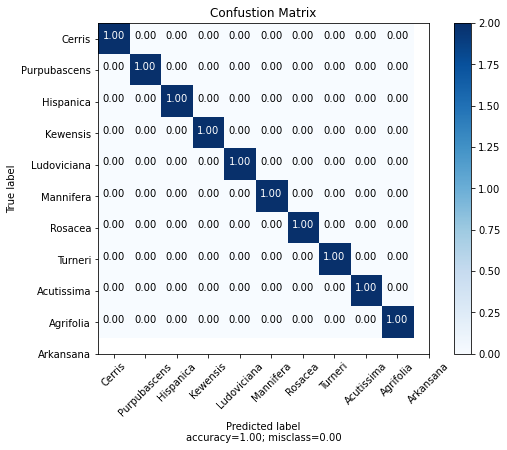

In [31]:
plot_confusion_matrix(cm=cm, target_names=cm_plot_labels, title='Confustion Matrix')